In [58]:
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
import pandas as pd
import catboost
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score

df = pd.read_feather('Step1.feather')
x_col = [] 
for i in df.drop(['ID','飆股'],axis=1).columns.tolist():
    if 'RSI' in i:
        x_col.append(i)

X = df[x_col]
y = df['飆股']
print(X.shape,y.shape)

pub_df = pd.read_feather('pub_x.feather')

i = 5
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)

train_pool = Pool(data=X_train, label=y_train)
test_pool = Pool(data=X_test, label=y_test)

model = CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    depth=6,
    loss_function='Logloss',
    eval_metric='F1',
    task_type='GPU',        # ✅ 使用 GPU
    devices='0',            # 使用第0張GPU
    verbose=1,
    class_weights = {0: 1, 1: 10}
)

model.fit(train_pool, eval_set=test_pool)

y_pred = model.predict(X_test)
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.4f}")

# 撈測試數據
submit = pd.read_csv('38_Public_Test_Set_and_Submmision_Template_V2/38_Public_Test_Set_and_Submmision_Template_V2/submission_template_public.csv')
# 預測機率
submit['飆股'] = model.predict_proba(pub_df[x_col])[:,1]
# 根據i保存
submit.to_csv(f'submit_{i}.csv',index=False)


(20000, 8) (20000,)
0:	learn: 0.7216839	test: 0.4577465	best: 0.4577465 (0)	total: 9.84ms	remaining: 974ms
1:	learn: 0.7300885	test: 0.4800000	best: 0.4800000 (1)	total: 17.9ms	remaining: 875ms
2:	learn: 0.7457870	test: 0.4743083	best: 0.4800000 (1)	total: 26.5ms	remaining: 857ms
3:	learn: 0.7361963	test: 0.5316973	best: 0.5316973 (3)	total: 33.3ms	remaining: 800ms
4:	learn: 0.7178695	test: 0.5338809	best: 0.5338809 (4)	total: 45.6ms	remaining: 866ms
5:	learn: 0.7255886	test: 0.5371901	best: 0.5371901 (5)	total: 58.2ms	remaining: 912ms
6:	learn: 0.7387457	test: 0.5383023	best: 0.5383023 (6)	total: 70.7ms	remaining: 940ms
7:	learn: 0.7370054	test: 0.5394191	best: 0.5394191 (7)	total: 78.7ms	remaining: 905ms
8:	learn: 0.7329435	test: 0.5394191	best: 0.5394191 (7)	total: 86.7ms	remaining: 877ms
9:	learn: 0.7268371	test: 0.5508475	best: 0.5508475 (9)	total: 95.1ms	remaining: 856ms
10:	learn: 0.7340174	test: 0.5450734	best: 0.5508475 (9)	total: 105ms	remaining: 849ms
11:	learn: 0.7343071	te

In [59]:
submit['飆股'] = submit['飆股'].apply(lambda x: 1 if x >= 0.5 else 0)
submit['飆股'].value_counts()

飆股
0    24531
1      577
Name: count, dtype: int64

In [23]:
submit.to_csv(f'submit_{i}.csv',index=False)

1. 技術指標_月RSI(10): 35.0084
2. 技術指標_RSI(5): 31.9645
3. 技術指標_週RSI(5): 23.4228
4. 技術指標_季RSI(10): 9.6043
5. 技術指標_RSI(10): 0.0000


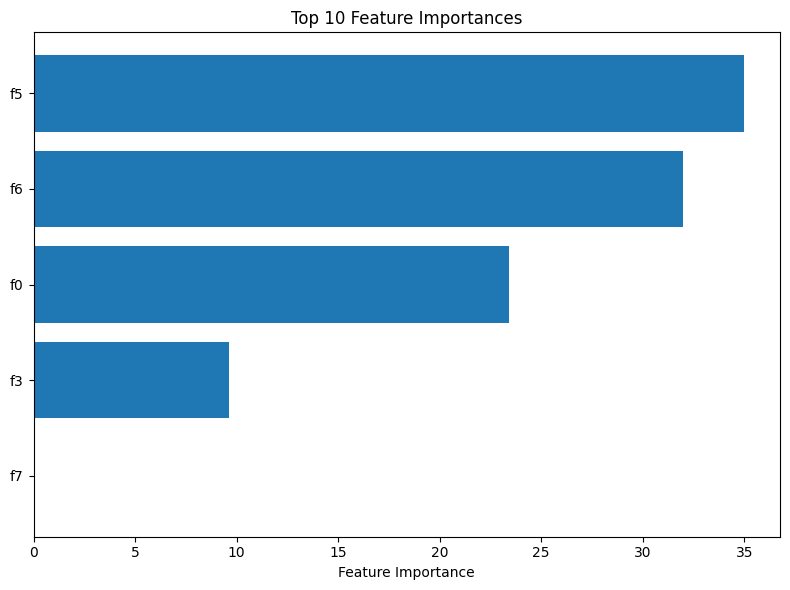

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# 取得特徵重要度
importances = model.get_feature_importance()

# 假設你沒有 feature names，就用預設 f0, f1, f2...
feature_names = [f"f{i}" for i in range(len(importances))]

# 取得前10名的重要度與名稱
top_n = 5
indices = np.argsort(importances)[::-1][:top_n]  # 由大到小排序
top_features = [feature_names[i] for i in indices]
top_importances = importances[indices]
# 顯示數值
for i, (name, score) in enumerate(zip(top_features, top_importances)):
    print(f"{i+1}. {x_col[int(name[1:])]}: {score:.4f}")

# 繪圖
plt.figure(figsize=(8, 6))
plt.barh(range(top_n), top_importances[::-1], align='center')
plt.yticks(range(top_n), top_features[::-1])
plt.xlabel("Feature Importance")
plt.title("Top 10 Feature Importances")
plt.tight_layout()
plt.show()

In [ ]:
1. 技術指標_月RSI(10): 22.1459
2. 技術指標_RSI(10): 21.9069
3. 技術指標_週RSI(5): 16.9871
4. 上市加權指數前6天收盤價: 16.3336
5. 賣超第2名分點前12天賣金額(千): 13.2845
6. 賣超第11名分點賣張: 9.3421
7. 買超第4名分點前6天買金額(千): 0.0000
8. 買超第4名分點前6天買均價: 0.0000
9. 買超第4名分點前6天賣均張: 0.0000
10. 買超第4名分點前6天買均張: 0.0000

1. 技術指標_Alpha(250D): 35.0077
2. 技術指標_RSI(5): 33.6154
3. 技術指標_週RSI(10): 12.4511
4. 上市加權指數前8天收盤價: 8.2393
5. 買超第3名分點前2天賣均價: 7.5044
6. 日投信_投信買均價: 3.1822
7. 上市加權指數20天成交量波動度: 0.0000
8. 買超第4名分點前6天買金額(千): 0.0000
9. 買超第4名分點前6天賣均張: 0.0000
10. 買超第4名分點前6天買均張: 0.0000

1. 技術指標_RSI(10): 23.5413
2. 技術指標_季K(9): 13.5431
3. 技術指標_月RSI(10): 10.6961
4. 外資券商_前16天分點成交力(%): 6.4363
5. 技術指標_Alpha(250D): 6.0148
6. 個股19天乖離率: 5.3877
7. 賣超第6名分點前4天買均價: 4.9061
8. 買超第8名分點前5天買筆數: 4.1041
9. 技術指標_RSI(5): 3.9994
10. 技術指標_週RSI(10): 3.8634

1. 賣超第10名分點前20天金額增減(千): 24.7671
2. 技術指標_月RSI(10): 23.2320
3. 技術指標_週RSI(10): 22.2424
4. 技術指標_RSI(5): 14.9667
5. 買超第10名分點前8天張增減: 8.6892
6. 賣超第5名分點前6天買張: 6.1025
7. 上市加權指數20天成交量波動度: 0.0000
8. 買超第4名分點前6天買張: 0.0000
9. 買超第4名分點前6天賣筆數: 0.0000
10. 買超第4名分點前6天買筆數: 0.0000

# 發現RSI有用
# 先篩RSI